# #1 Emissions Datathon - Permian, Mean Pixel values and CNN

### Prepare Dataframe

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.pyplot import *
import imageio
from skimage.io import imread

from tqdm import tqdm

import cv2   #For image processing

import tensorflow as tf
#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model



from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of data
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv, rgba2rgb
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import io, color

In [2]:
image_train = Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Train2')

dir_name = r'C:\Users\vasan\OneDrive\EmissionsDatathon\Zeroing Methane Emissions - Dataset'
filename_suffix = 'csv'

In [3]:
filepaths = pd.Series(list(image_train.glob(r'**/*.png')), name='Filepath').astype(str)

In [4]:
filepaths.head()

0    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
1    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
2    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
3    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
4    C:\Users\vasan\OneDrive\EmissionsDatathon\Data...
Name: Filepath, dtype: object

In [5]:
df_filepaths = filepaths.to_frame()

In [6]:
res = os.listdir(image_train)
df_filepaths['Name'] = pd.DataFrame (res, columns = ['FileName'])

In [7]:
df_filepaths['candidate_id'] = [x.split('_')[-0] for x in df_filepaths['Name']]

In [8]:
df_filepaths.to_excel("all.xlsx")  

In [9]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_csv("plume_attribution_2019-2022 Jeremy Zhao.csv", thousands=',', skiprows = skiprows)
#df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,Unnamed: 0,source_id,candidate_id,plume_lat,plume_lon,date,source_type,ipcc,qplume,sigma_qplume,time_of_detection,plume_tif,rgb_tif
0,0,A0001,GAO20210712t153850p0000-A,40.586588,-104.82330,2021-07-12 00:00:00,landfill,6A Solid Waste Disposal On Land,198.690714,56.089373,NaN,NaN,NaN
1,1,A0002,GAO20210720t152559p0000-A,40.574605,-104.68813,2021-07-20 00:00:00,livestock,3A2 Manure Management,659.384534,215.976289,NaN,NaN,NaN
2,2,A0002,GAO20210712t153850p0000-B,40.574387,-104.68855,2021-07-12 00:00:00,livestock,3A2 Manure Management,458.494606,167.196121,NaN,NaN,NaN
3,3,A0002,GAO20210718t152410p0000-B,40.573827,-104.68812,2021-07-18 00:00:00,livestock,3A2 Manure Management,242.145473,140.004235,NaN,NaN,NaN
4,4,A0003,GAO20210712t153850p0000-C,40.572121,-104.68871,2021-07-12 00:00:00,livestock,3A2 Manure Management,425.330806,171.220361,NaN,NaN,NaN


In [10]:
df['candidate_id'].nunique()

7292

In [11]:
df.shape

(8752, 13)

In [12]:
dup = df[df['candidate_id'].duplicated() == True]

In [13]:
#dup.to_excel("dup.xlsx")  

In [14]:
#df.to_excel("df.xlsx")  

In [15]:
df = df.drop_duplicates(subset='candidate_id', keep="first")

In [16]:
print(df.shape)
print(df_filepaths.shape)

(7292, 13)
(3059, 3)


In [17]:
df2 = pd.merge(df, df_filepaths, on='candidate_id')

In [18]:
print(df2.shape)

(3058, 15)


In [19]:
df2.head()

,Unnamed: 0,source_id,candidate_id,plume_lat,plume_lon,date,source_type,ipcc,qplume,sigma_qplume,time_of_detection,plume_tif,rgb_tif,Filepath,Name
0,0,A0001,GAO20210712t153850p0000-A,40.586588,-104.82330,2021-07-12 00:00:00,landfill,6A Solid Waste Disposal On Land,198.690714,56.089373,NaN,NaN,NaN,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20210712t153850p0000-A_r174_c3465-plume.png
1,1,A0002,GAO20210720t152559p0000-A,40.574605,-104.68813,2021-07-20 00:00:00,livestock,3A2 Manure Management,659.384534,215.976289,NaN,NaN,NaN,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20210720t152559p0000-A_r380_c5956-plume.png
2,2,A0002,GAO20210712t153850p0000-B,40.574387,-104.68855,2021-07-12 00:00:00,livestock,3A2 Manure Management,458.494606,167.196121,NaN,NaN,NaN,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20210712t153850p0000-B_r468_c6000-plume.png
3,3,A0002,GAO20210718t152410p0000-B,40.573827,-104.68812,2021-07-18 00:00:00,livestock,3A2 Manure Management,242.145473,140.004235,NaN,NaN,NaN,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20210718t152410p0000-B_r406_c6016-plume.png
4,4,A0003,GAO20210712t153850p0000-C,40.572121,-104.68871,2021-07-12 00:00:00,livestock,3A2 Manure Management,425.330806,171.220361,NaN,NaN,NaN,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,GAO20210712t153850p0000-C_r524_c5997-plume.png


In [20]:
df2['candidate_id'].nunique()

3058

In [21]:
df2=df2.dropna(subset=["qplume"])

In [22]:
df2.shape

(3056, 15)

In [23]:
print("Upper limit",df2['qplume'].mean() + 3*df2['qplume'].std())
print("Lower limit",df2['qplume'].mean() - 3*df2['qplume'].std())

Upper limit 2805.5444311201527
Lower limit -1772.573140739497


In [24]:
df2 = df2[(df2['qplume'] < 2805.5444311201527)]
df2.shape

(2980, 15)

In [25]:
df2.to_excel("allfinal.xlsx")  

### Image Processing

In [26]:
#def image_processing(fil):
#Open image and import it as a numpy array
#    image2 = imread(fil)
    
#    feature_matrix = np.zeros((217,217))
    
#    for i in range(0,image2.shape[0]):
#        for j in range(0,image2.shape[1]):
#            feature_matrix[i][j] = ((int(image2[i,j,0]) + int(image2[i,j,1]) + int(image2[i,j,2]))/3)
        
#    features = np.reshape(feature_matrix, (217*217))
    
#    return features

In [27]:
def image_processing(fil):
#Open image and import it as a numpy array
    with open(fil, 'rb') as f:
        im1 = f.read()
    im1_data = np.frombuffer(im1, dtype='uint8')
#Read the numpy arrays as color images in OpenCV
    image_bgr2 = cv2.imdecode(im1_data, cv2.IMREAD_COLOR)
#Convert to HSV for creating a mask
    image_hsv = cv2.cvtColor(image_bgr2, cv2.COLOR_BGR2HSV)
#Convert to grayscale that will actually be used for training, instead of color image 
    image_gray = cv2.cvtColor(image_bgr2, cv2.COLOR_BGR2GRAY)
#Create a mask that detects the red rectangular tags present in each image
    mask = cv2.inRange(image_hsv, (0,255,255), (0,255,255))
#Get the coordinates of the red rectangle in the image, 
    #But take entire image if mask fails to detect the red rectangle
    if len(np.where(mask != 0)[0]) != 0:
        y1 = min(np.where(mask != 0)[0])
        y2 = max(np.where(mask != 0)[0])
    else:
        y1 = 0                                     
        y2 = len(mask)
    if len(np.where(mask != 0)[1]) != 0:
        x1 = min(np.where(mask != 0)[1])
        x2 = max(np.where(mask != 0)[1])
    else:
        x1 = 0
        x2 = len(mask[0])
#Crop the grayscle image along those coordinates
    image_cropped = image_gray[y1:y2, x1:x2]
    if image_cropped.size ==0:
        print(fil)
        return image_cropped
    else:
    #Resize the image to 128x128 pixels size
        image_128x128 = cv2.resize(image_cropped, (128, 128))
#Save image as in form of array of 10000x1
        image_arr = image_128x128.flatten()
    return image_arr

In [28]:
#Test Function
#fil = "C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Train/ang20190922t192642_ang20190922t192642-2_r4578_c217-plume.png"
#image_processing(fil)

In [29]:
image_list = []

In [30]:
for file in tqdm(df2['Filepath'].tolist()[:]):
    image_list.append(image_processing(file))

  2%|▏         | 65/2980 [00:00<00:09, 323.12it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210717t160446p0000-A_r83_c11006-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210716t172622p0000-1_r116_c4995-plume.png


  6%|▌         | 178/2980 [00:00<00:07, 358.71it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210513t145258p0000-1_r1185_c225-plume.png


 12%|█▏        | 347/2980 [00:01<00:08, 308.53it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210507t163418p0000-1_r879_c1189-plume.png


 16%|█▌        | 483/2980 [00:01<00:07, 323.69it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210726t181423p0000-P_r16958_c1929-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210804t162811p0000-E_r14612_c1583-plume.png


 18%|█▊        | 549/2980 [00:01<00:07, 318.71it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210726t203329p0000-A_r1107_c458-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210809t160357p0000-D_r4537_c6107-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210727t163026p0000-B_r3282_c7786-plume.png


 22%|██▏       | 642/2980 [00:02<00:08, 284.20it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210727t170837p0000-C_r3091_c8239-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210727t173519p0000-D_r4381_c7164-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210727t182830p0000-A_r1001_c11412-plume.png


 24%|██▍       | 714/2980 [00:02<00:07, 315.96it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210727t185504p0000-G_r1552_c10439-plume.png


 28%|██▊       | 848/2980 [00:02<00:06, 322.50it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210806t152440p0000-F_r4111_c7453-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210808t185754p0000-A_r5000_c901-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210731t175256p0000-C_r11521_c1367-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210804t153732p0000-A_r4134_c492-plume.png


 33%|███▎      | 994/2980 [00:03<00:05, 346.46it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210804t184014p0000-B_r3175_c7561-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210805t155713p0000-B_r7503_c2401-plume.png


 37%|███▋      | 1099/2980 [00:03<00:05, 343.97it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210806t160316p0000-B_r1124_c10938-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210806t160316p0000-F_r5482_c4647-plume.png


 39%|███▉      | 1172/2980 [00:03<00:05, 351.24it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210807t182406p0000-F_r905_c10730-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210807t181019p0000-C_r1525_c11102-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210808t183912p0000-A_r5586_c1143-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210808t185754p0000-D_r1766_c493-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210809t182539p0000-B_r2175_c9318-plume.png


 42%|████▏     | 1251/2980 [00:03<00:04, 368.65it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20210810t190554p0000-A_r3689_c612-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200718t182430p0001-C_r4488_c589-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200713t160826p0000-A_r4584_c561-plume.png


 45%|████▍     | 1330/2980 [00:04<00:04, 381.61it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200714t162941p0000-C_r4801_c6784-plume.png


 51%|█████▏    | 1533/2980 [00:04<00:03, 392.32it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200715t180121p0000-B_r11865_c1261-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200715t191219p0000-B_r3163_c703-plume.png


 55%|█████▌    | 1653/2980 [00:04<00:03, 382.12it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200718t182430p0000-C_r5045_c652-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200719t154650p0000-E_r510_c11874-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200723t180941p0000-B_r1201_c9354-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200723t182125p0000-C_r3408_c5284-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200719t185315p0000-D_r4912_c5136-plume.png


 60%|█████▉    | 1779/2980 [00:05<00:02, 406.81it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200721t160234p0000-C_r1738_c10339-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200721t161457p0000-E_r1930_c10688-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200724t171943p0000-D_r4029_c6972-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200723t174534p0000-D_r1392_c9686-plume.png


 63%|██████▎   | 1866/2980 [00:05<00:02, 419.69it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200805t183431p0000-B_r230_c8830-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200806t164042p0000-A_r46_c6304-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200807t163414p0000-A_r496_c411-plume.png


 66%|██████▌   | 1953/2980 [00:05<00:02, 406.77it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200804t182106p0000-A_r1423_c319-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200807t185425p0000-A_r382_c7789-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200807t182439p0000-C_r94_c5348-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200805t190335p0000-A_r381_c4588-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200805t192315p0000-A_r477_c7054-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200806t165004p0000-C_r231_c1453-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200806t173006p0000-B_r629_c3887-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200806t195450p0000-A_r328_c6738-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20200807t171423p0000-B_r199_c2674-plume.png
C:\Users\vasan\OneDr

 68%|██████▊   | 2034/2980 [00:05<00:02, 386.91it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20201110t182804p0000-A_r53_c219-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20201116t183823p0000-B_r1025_c953-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20201113t190013p0000-A_r3781_c4015-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20201123t195037p0000-B_r618_c829-plume.png


 72%|███████▏  | 2148/2980 [00:06<00:02, 363.20it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20201116t202002p0000-A_r6866_c6642-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\GAO20201122t184200p0000-A_r2284_c2497-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200901t204428-C_r9512_c170-plume.png


 75%|███████▍  | 2227/2980 [00:06<00:02, 375.60it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200727t202045-C_r6332_c174-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200727t211731-A_r6490_c95-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200828t192559-A_r5528_c424-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200722t194928-B_r5546_c421-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200708t202321-D_r2269_c116-plume.png


 77%|███████▋  | 2309/2980 [00:06<00:01, 390.86it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200708t203038-D_r4790_c390-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200723t190808-A_r8350_c144-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200828t190555-A_r8349_c114-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200722t193838-B_r4955_c396-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200901t194828-D_r4441_c374-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200723t213727-C_r2534_c376-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200901t213415-A_r2498_c565-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200714t201525-A_r1537_c175-plume.png


 80%|████████  | 2388/2980 [00:06<00:01, 377.57it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200727t212812-A_r1985_c-64-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200723t204848-C_r8594_c112-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200828t214929-A_r1861_c452-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200714t204231-A_r308_c586-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20200901t212157-A_r1484_c294-plume.png


 87%|████████▋ | 2580/2980 [00:07<00:01, 355.58it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220501t173311-A_r14980_c567-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220323t210157-D_r14740_c564-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220324t170857-B_r6906_c448-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220415t182136-H_r19279_c119-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220324t174703-A_r3728_c-34-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220415t184411-E_r26765_c212-plume.png


 91%|█████████ | 2699/2980 [00:07<00:00, 373.55it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220324t195537-C_r16009_c454-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220430t172719-C_r11205_c169-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220501t164820-A_r7931_c238-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220325t185825-C_r14410_c258-plume.png


 93%|█████████▎| 2777/2980 [00:07<00:00, 377.18it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220415t165631-G_r17833_c288-plume.png


 97%|█████████▋| 2893/2980 [00:08<00:00, 372.04it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220430t192857-C_r17067_c211-plume.png


100%|██████████| 2980/2980 [00:08<00:00, 357.18it/s]

C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220520t195513-B_r3076_c534-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220520t201527-A_r2148_c346-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220520t193549-D_r564_c562-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220523t201543-A_r156_c151-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220520t201527-B_r8706_c220-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220520t204322-A_r1946_c350-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220523t193759-A_r6121_c398-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220523t191435-F_r1105_c175-plume.png
C:\Users\vasan\OneDrive\EmissionsDatathon\Dataset\Data\Train2\ang20220530t185353-A_r5149_c359-plume.png


In [31]:
X = np.array(image_list)

C:\Users\vasan\AppData\Local\Temp/ipykernel_18896/3901937091.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(image_list)


In [32]:
X

array([array([  0,   7,  60, ..., 106, 106, 106], dtype=uint8),
       array([50, 51, 51, ..., 45, 45, 44], dtype=uint8),
       array([67, 68, 68, ..., 73, 73, 75], dtype=uint8), ...,
       array([214, 214, 214, ..., 142, 142, 142], dtype=uint8),
       array([213, 213, 220, ...,  51,  58,  58], dtype=uint8),
       array([186, 180, 176, ..., 164, 167, 164], dtype=uint8)],
      dtype=object)

In [33]:
np.save('processed_128x128_image.npy',X,allow_pickle=True)

In [34]:
pic_array = np.load('processed_128x128_image.npy',allow_pickle=True)

In [35]:
#remove non 16384 dimension out of the numpy array
X =[]
exclude =[]
for i in range(len(pic_array)):
    if pic_array[i].shape == (16384,):
        X.append(pic_array[i])
    else:
        exclude.append(i)
X =np.array(X)
#also remove from the dataframe
df2.drop(df2.index[exclude],inplace=True)

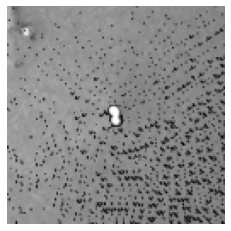

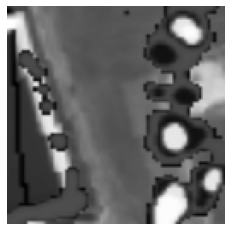

In [36]:
np.random.seed(18)
for i in np.random.randint(0, len(pic_array), 2):
    plt.figure()
    plt.imshow(pic_array[i].reshape(128, 128), cmap='gray'), plt.axis('off')

### Preparing dataset for Model

In [37]:
Y = np.array(df2.qplume.tolist())

In [38]:
Y

array([198.690714  , 659.384534  , 458.494606  , ...,  58.74497328,
       262.239608  ,  78.31375757])

In [39]:
print(X.shape)
print(Y.shape)

(2880, 16384)
(2880,)


In [40]:
# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

In [41]:
img_rows, img_cols = 128, 128
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_val.shape

(576, 128, 128, 1)

In [42]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

In [43]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(1728, 128, 128, 1)
(1728,)
(576, 128, 128, 1)
(576,)
(576, 128, 128, 1)
(576,)


### Model

In [44]:
#Define a Convolutional Neural Network Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
#model.add(Dense(n_classes, activation='softmax'))
model.add(Dense(1, activation='relu'))
learning_rate = 0.001

model.compile(loss = 'mse',
              optimizer = Adam(learning_rate))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 124, 124, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                        

In [45]:
save_at = "model_regression2.hdf5"
save_best2 = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

In [46]:
np.isnan(X).any()

False

In [47]:
np.isnan(Y).any()

False

In [48]:
#Train the CNN

history = model.fit( X_train, Y_train, 
                    epochs = 15, batch_size = 100, 
                    callbacks=[save_best2], verbose=1, 
                   validation_data = (X_val, Y_val))

Epoch 1/15
18/18 [==============================] - 39s 2s/step - loss: 203482.3750 - val_loss: 306732.1250
Epoch 2/15
18/18 [==============================] - 41s 2s/step - loss: 142457.3125 - val_loss: 352700.0938
Epoch 3/15
18/18 [==============================] - 42s 2s/step - loss: 137561.5938 - val_loss: 340537.9062
Epoch 4/15
18/18 [==============================] - 40s 2s/step - loss: 121477.7891 - val_loss: 279024.3125
Epoch 5/15
18/18 [==============================] - 36s 2s/step - loss: 99609.2969 - val_loss: 297658.4375
Epoch 6/15
18/18 [==============================] - 39s 2s/step - loss: 87403.3047 - val_loss: 220199.8906
Epoch 7/15
18/18 [==============================] - 35s 2s/step - loss: 77429.4141 - val_loss: 256155.7812
Epoch 8/15
18/18 [==============================] - 35s 2s/step - loss: 54211.9570 - val_loss: 198766.8906
Epoch 9/15
18/18 [==============================] - 32s 2s/step - loss: 38880.6953 - val_loss: 209734.3750
Epoch 10/15
18/18 [==============

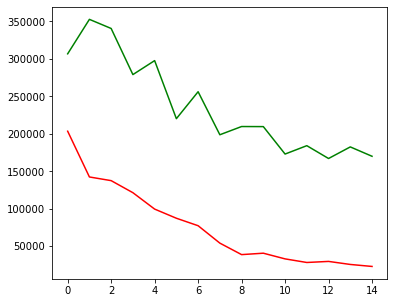

In [49]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='g')
plt.show()

### Predication

In [50]:
Y_pred = np.round(model.predict(X_test))

18/18 [==============================] - 2s 80ms/step


In [51]:
# Calculate the mean squared error
mse = mean_squared_error(Y_test, Y_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

r2 = r2_score(Y_test, Y_pred)
print("Test R^2 Score: {:.5f}".format(r2))

Root Mean Squared Error: 414.57528166082085
Test R^2 Score: 0.29993


### Submission

In [52]:
image_sub = []

In [53]:
image_test = Path('C:/Users/vasan/OneDrive/EmissionsDatathon/Dataset/Data/Test')

In [54]:
testpaths = pd.Series(list(image_test.glob(r'**/*.png')), name='Testpath').astype(str)

In [55]:
df_testpaths = testpaths.to_frame()

In [56]:
res = os.listdir(image_test)
df_testpaths['Name'] = pd.DataFrame (res, columns = ['TestName'])

In [57]:
df_testpaths

,Testpath,Name
0,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,01A.png
1,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,02A.png
2,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,03A.png
3,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,04A.png
4,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,05A.png
5,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,06A.png
6,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,07A.png
7,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,08A.png
8,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,09A.png
9,C:\Users\vasan\OneDrive\EmissionsDatathon\Data...,10A.png


In [58]:
for file in tqdm(df_testpaths['Testpath'].tolist()[:]):
    image_sub.append(image_processing(file))

100%|██████████| 20/20 [00:00<00:00, 402.97it/s]


In [59]:
X_sub = np.array(image_sub)

In [60]:
np.save('sub_image.npy',X_sub,allow_pickle=True)

In [61]:
X_test

array([[[[ 73],
         [ 73],
         [ 73],
         ...,
         [142],
         [142],
         [142]],

        [[ 73],
         [ 73],
         [ 73],
         ...,
         [142],
         [142],
         [142]],

        [[ 73],
         [ 73],
         [ 73],
         ...,
         [145],
         [145],
         [145]],

        ...,

        [[183],
         [183],
         [183],
         ...,
         [ 76],
         [ 76],
         [ 76]],

        [[187],
         [187],
         [187],
         ...,
         [ 76],
         [ 76],
         [ 76]],

        [[187],
         [187],
         [187],
         ...,
         [ 76],
         [ 76],
         [ 76]]],


       [[[153],
         [153],
         [154],
         ...,
         [133],
         [133],
         [134]],

        [[154],
         [156],
         [156],
         ...,
         [134],
         [135],
         [135]],

        [[155],
         [155],
         [156],
         ...,
         [136],
         [

In [62]:
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)
X_sub = X_sub.reshape(X_sub.shape[0], img_rows, img_cols, 1)
X_sub

array([[[[ 51],
         [ 51],
         [ 51],
         ...,
         [106],
         [108],
         [109]],

        [[ 52],
         [ 50],
         [ 52],
         ...,
         [101],
         [ 95],
         [ 86]],

        [[ 56],
         [ 53],
         [ 55],
         ...,
         [ 93],
         [ 81],
         [ 63]],

        ...,

        [[ 67],
         [ 65],
         [ 72],
         ...,
         [ 66],
         [ 62],
         [ 61]],

        [[ 84],
         [ 65],
         [ 63],
         ...,
         [ 80],
         [ 82],
         [ 75]],

        [[102],
         [ 68],
         [ 73],
         ...,
         [ 72],
         [ 73],
         [ 76]]],


       [[[  0],
         [  0],
         [  0],
         ...,
         [  6],
         [  8],
         [  1]],

        [[  0],
         [  0],
         [  0],
         ...,
         [ 81],
         [ 93],
         [ 11]],

        [[  0],
         [  0],
         [ 48],
         ...,
         [121],
         [

In [63]:
Y_sub = np.round(model.predict(X_sub))

1/1 [==============================] - 0s 163ms/step


In [64]:
Y_sub

array([[561.],
       [ 96.],
       [ 87.],
       [261.],
       [137.],
       [141.],
       [403.],
       [ 78.],
       [269.],
       [127.],
       [173.],
       [ 51.],
       [ 16.],
       [169.],
       [806.],
       [261.],
       [101.],
       [180.],
       [183.],
       [298.]], dtype=float32)

In [65]:
np.savetxt('06_Localise_CNN_Outliers2.csv', Y_sub, delimiter=',')

In [66]:
X_sub.shape

(20, 128, 128, 1)